In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
df = pd.read_csv('../data/DOCKSTRING/target_specific/LCK.csv')

In [5]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()
sas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qeds'].values.reshape(-1,1))
logp_scaler.fit(df['logps'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsas'].values.reshape(-1,1))
sas_scaler.fit(df['sas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qeds'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logps'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsas'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))
df['sas'] = sas_scaler.transform(df['sas'].values.reshape(-1,1))

In [6]:
df

smiles  affinity      qeds  \
0              O=C1C(=O)C(c2ccc(O)c(O)c2)Oc2cc(O)cc(O)c21  0.561224  0.484235   
1                        O=S(=O)(c1cccc2cnccc12)N1CCCNCC1  0.591837  0.952457   
2                         CCN1/C(=C/C(C)=O)Sc2ccc(OC)cc21  0.765306  0.810517   
3       Cc1ccc(NC(=O)c2ccc(CN3CCN(C)CC3)cc2)cc1Nc1nccc...  0.438776  0.405727   
4                             c1ccc2c(-c3ccncc3)c[nH]c2c1  0.693878  0.664394   
...                                                   ...       ...       ...   
260055              CCOc1ccc(Cl)cc1S(=O)(=O)n1nnc2ccccc21  0.591837  0.769497   
260056                        O=C(NN=C1CCCC1)c1ccc(Cl)cc1  0.632653  0.830084   
260057  Cc1cccc(-c2nc3ccccc3n3c(-c4ccccc4)c4c(=O)n(C)c...  0.530612  0.404260   
260058          COC(=O)c1cn(C(=O)c2ccc(C)c(C)c2)c2ccccc12  0.510204  0.712374   
260059           Cc1cccc(NC(=O)c2ncn3c2C(=O)NC[C@@H]3C)c1  0.520408  0.929370   

           logps     tpsas       sas   molwts  split  
0       0.437980  0.249980  0.317183  302.238  train  
1       0.430486  0.125302  0.177960  291.376   test  
2       0.508913  0.059413  0.215043  249.335  train  
3       0.574285  0.173532  0.195539  493.615  train  
4       0.516262  0.057683  0.120403  194.237  train  
...          ...       ...       ...      ...    ...  
260055  0.494531  0.148994  0.178365  337.788  train  
260056  0.506448  0.083387  0.143127  236.702  train  
260057  0.578132  0.123290  0.226081  446.510  train  
260058  0.537730  0.097144  0.147824  307.349  train  
260059  0.453066  0.152896  0.287503  284.319   test  

[260060 rows x 8 columns]

In [7]:
SMI_MAX_SIZE= -1
with open('../data/DOCKSTRING/smiles_corpus.txt', 'w') as f:
    train = []
    test = []        
    for i, row in df.iterrows():
        if row['split'] == "test":
            test.append(list(row.values))
        else:
            train.append(list(row.values))
        f.write(split(row['smiles'] +'\n'))
        
        if SMI_MAX_SIZE < len(row['smiles']):
            SMI_MAX_SIZE = len(row['smiles'])
f.close()
print("SMI_MAX_SIZE ", SMI_MAX_SIZE)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

SMI_MAX_SIZE  241


In [8]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/DOCKSTRING/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

Building Vocab


In [9]:

class CustomTargetDataset(Dataset):
    def __init__(self, dataframe, SmilesVocab, properties_list):
        self.dataframe = dataframe
        self.smiles_vocab = SmilesVocab
        self.property_list = properties_list
        self.build()
        
    def build(self):
        smiles, properties, affinities= [],[],[]
        smiles_encoding = []
        for i, row in self.dataframe.iterrows():
            smi = row['smiles']
            # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
            newsmi = smi
            smiles.append(newsmi)
            smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE, with_eos=True, with_sos=True))
            props = []
            for p in self.property_list:
                props.append(row[p])
            properties.append(props)

        self.smiles_encodings = torch.tensor(smiles_encoding)
        self.properties = torch.tensor(properties)
        self.smiles = smiles
        # self.affinities = torch.tensor(affinities)
        print("dataset built")
        
    def __len__(self):
        return len(self.properties)
    
    def __getitem__(self, index):
        return {
            "smiles_rep": self.smiles_encodings[index],
            "properties": self.properties[index],
            "smiles":self.smiles[index]
        }

In [10]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

In [11]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layers = nn.ModuleList([nn.Linear(1, d_model) for _ in range(n_properties)])
        self.layer_final = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(n_properties)])
    def forward(self, x):
        outs = [self.layer_final[i](F.relu(self.layers[i](x[:,i].unsqueeze(1)))) for i, layer in enumerate(self.layers)]
        # for i, layer in enumerate(self.layers):
        #     out = self.layers[i](x[:,i])
        #     out = F.relu(out)
        #     x = self.layer_final[i](out)        
        return torch.stack(outs, dim=1)

In [12]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

In [13]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerDecoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerDecoder(decoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))
        self.property_encoder = PropertyEncoder(d_model,n_properties=n_properties)
        
    def forward(self, x, property):
        property = self.property_encoder(property)
        
        x = self.embed(x)
        x = self.smile_pe(x)
    
        mask = set_up_causal_mask(x.shape[1]).to(x.device)
        x = self.trfm(tgt=x,
                      memory=property,
                      tgt_mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

In [14]:
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(data_loader):
        # data = {k: v.to(device) for k, v in data.items()}
        data['smiles_rep'] = data['smiles_rep'].to(device)
        data['properties'] = data['properties'].to(device)
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        y = data['smiles_rep'][:,1:]
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            # data = {k: v.to(device) for k, v in data.items()}
            data['smiles_rep'] = data['smiles_rep'].to(device)
            data['properties'] = data['properties'].to(device)
            
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            y = data['smiles_rep'][:,1:]
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),y.contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)


In [15]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)
        

In [16]:
class Sampler:
    def __init__(self, model, vocab, temperature=1.0):
        self.model = model
        self.vocab = vocab
        self.temperature = temperature
    
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq)
            # return
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property) / self.temperature
                # print(logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile[1:]: # first is start token
                    if char == "<eos>" :
                        break
                    final_smile += char
                samples.append(final_smile)
        return samples
            

In [17]:
def sample_a_bunch(model, dataloader, greedy=False, temperature=1.0):
    sampler = Sampler(model, smiles_vocab, temperature=temperature)
    print("Temperature: ", temperature)
    model.eval()
    samples = []
    properties = []
    og_smiles = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            ogs = data['smiles']
            samples += smiles
            og_smiles += ogs
            print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples, og_smiles

In [18]:
from rdkit import Chem

def is_valid_smiles(smiles):
    """Check if a SMILES string is valid."""
    return Chem.MolFromSmiles(smiles) is not None

def compute_metrics(train_SMILES, test_SMILES, predicted_SMILES):
    # Compute validity
    valid_predicted = [smiles for smiles in predicted_SMILES if is_valid_smiles(smiles)]
    validity = len(valid_predicted) / len(predicted_SMILES) if predicted_SMILES else 0

    # Compute novelty
    novel_predicted = [smiles for smiles in valid_predicted if smiles not in train_SMILES]
    novelty = len(novel_predicted) / len(valid_predicted) if valid_predicted else 0

    # Compute uniqueness
    unique_predicted = set(valid_predicted)
    uniqueness = len(unique_predicted) / len(valid_predicted) if valid_predicted else 0

    return {
        'Validity': validity,
        'Novelty': novelty,
        'Uniqueness': uniqueness
    }


In [20]:
config = {
    'batch_size' :512,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':6,
    'hidden_units': 1024,
    'lr': 1e-6,
    'epochs': 2,
    'properties': sorted(['affinity', 'qeds', 'logps','tpsas', 'sas'])
}
config['run_name'] = "LCK_DOCKSTRING_"+ "_".join(prop for prop in config['properties'])
print(config)

{'batch_size': 512, 'd_model': 512, 'n_heads': 8, 'n_layers': 6, 'hidden_units': 1024, 'lr': 1e-06, 'epochs': 2, 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'], 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'}


In [23]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [24]:
# train_dataset = CustomTargetDataset(train_df, smiles_vocab, properties_list=config['properties'])
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])

dataset built


In [25]:
# train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, num_workers=12)
test_loader = DataLoader(test_dataset, batch_size=2048, shuffle=True, num_workers=12)

In [26]:
data =  next(iter(test_loader))
print(data.keys())

dict_keys(['smiles_rep', 'properties', 'smiles'])


In [27]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

In [28]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [ ]:
config

{'batch_size': 512,
 'd_model': 512,
 'n_heads': 8,
 'n_layers': 6,
 'hidden_units': 1024,
 'lr': 1e-06,
 'epochs': 2,
 'properties': ['affinity', 'logps', 'qeds', 'sas', 'tpsas'],
 'run_name': 'LCK_DOCKSTRING_affinity_logps_qeds_sas_tpsas'}

In [30]:
model = load_model(config)

No of GPUs available 2


In [31]:
# def sample_a_bunch(model, dataloader, greedy=False):
#     sampler = Sampler(model, smiles_vocab)
#     model.eval()
#     samples = []
#     properties = []
#     with torch.no_grad():
#         for i, data in enumerate(dataloader):
#             # data = {k: v.to(device) for k, v in data.items()}
#             smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
#             properties += data['properties'].cpu().numpy().tolist()
#             samples += smiles
#             print( 'Sampling: iteration: {}/{}'.format(i, len(dataloader)), end='\r')
#             if len(samples) >= 1000:
#                 break
#     return np.array(properties), samples

In [32]:
properties, samples, og_smiles = sample_a_bunch(model, test_loader, greedy=False, temperature=0.5)
train_SMILES = train_df['smiles'].tolist()
compute_metrics(train_SMILES, og_smiles, samples)

Temperature:  0.5


{'Validity': 0.9140625,
 'Novelty': 0.9882478632478633,
 'Uniqueness': 0.999465811965812}

In [ ]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [ ]:
print("validity rate", calculate_validity_rate(samples))

In [ ]:
qeds, logps, tpsas, sas, molwt , og_props , smi= calc_properties(properties, samples)

In [ ]:
with open('../checkpoints/'+config['run_name'] +'/RawPreferenceData.pkl', 'rb') as f:
    new_target_smiles, new_target_properties, new_sampled_smiles = pickle.load(f)
    
new_sampled_smiles = np.array(new_sampled_smiles)
calculate_validity_rate(new_sampled_smiles[:,0])

0.0018660287081339712

In [ ]:
og_affinity = og_props[:,0]
og_logp = og_props[:,1]
og_qeds = og_props[:,2]
og_sas = og_props[:,3]
og_tpsa = og_props[:,4]

In [ ]:
import seaborn as sns

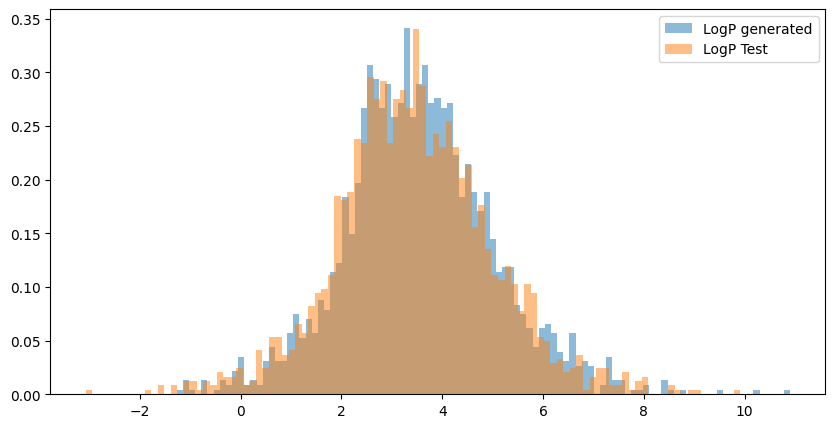

In [ ]:
#histogram density plot using matplotlib
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

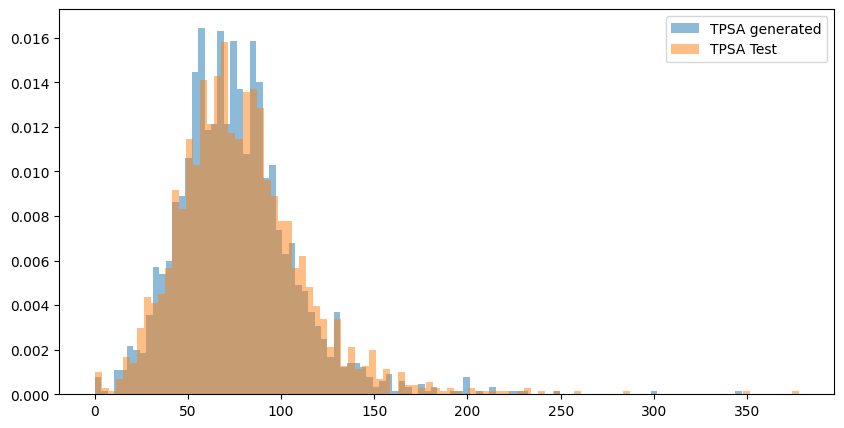

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

In [ ]:
stats = pd.DataFrame({
                      "SAS_pred":sas, 
                      "QED_pred":qeds, 
                      "LogP_pred":logps, 
                    #   "molwt_pred":molwt, 
                      "TPSA_pred":tpsas})
stats['SAS_og'] = sas_scaler.inverse_transform(og_sas.reshape(-1,1)).flatten()
stats['QED_og'] = qed_scaler.inverse_transform(og_qeds.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()
# stats['molwt_og'] = molwt_scaler.inverse_transform(og_molwt.reshape(-1,1)).flatten()
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()

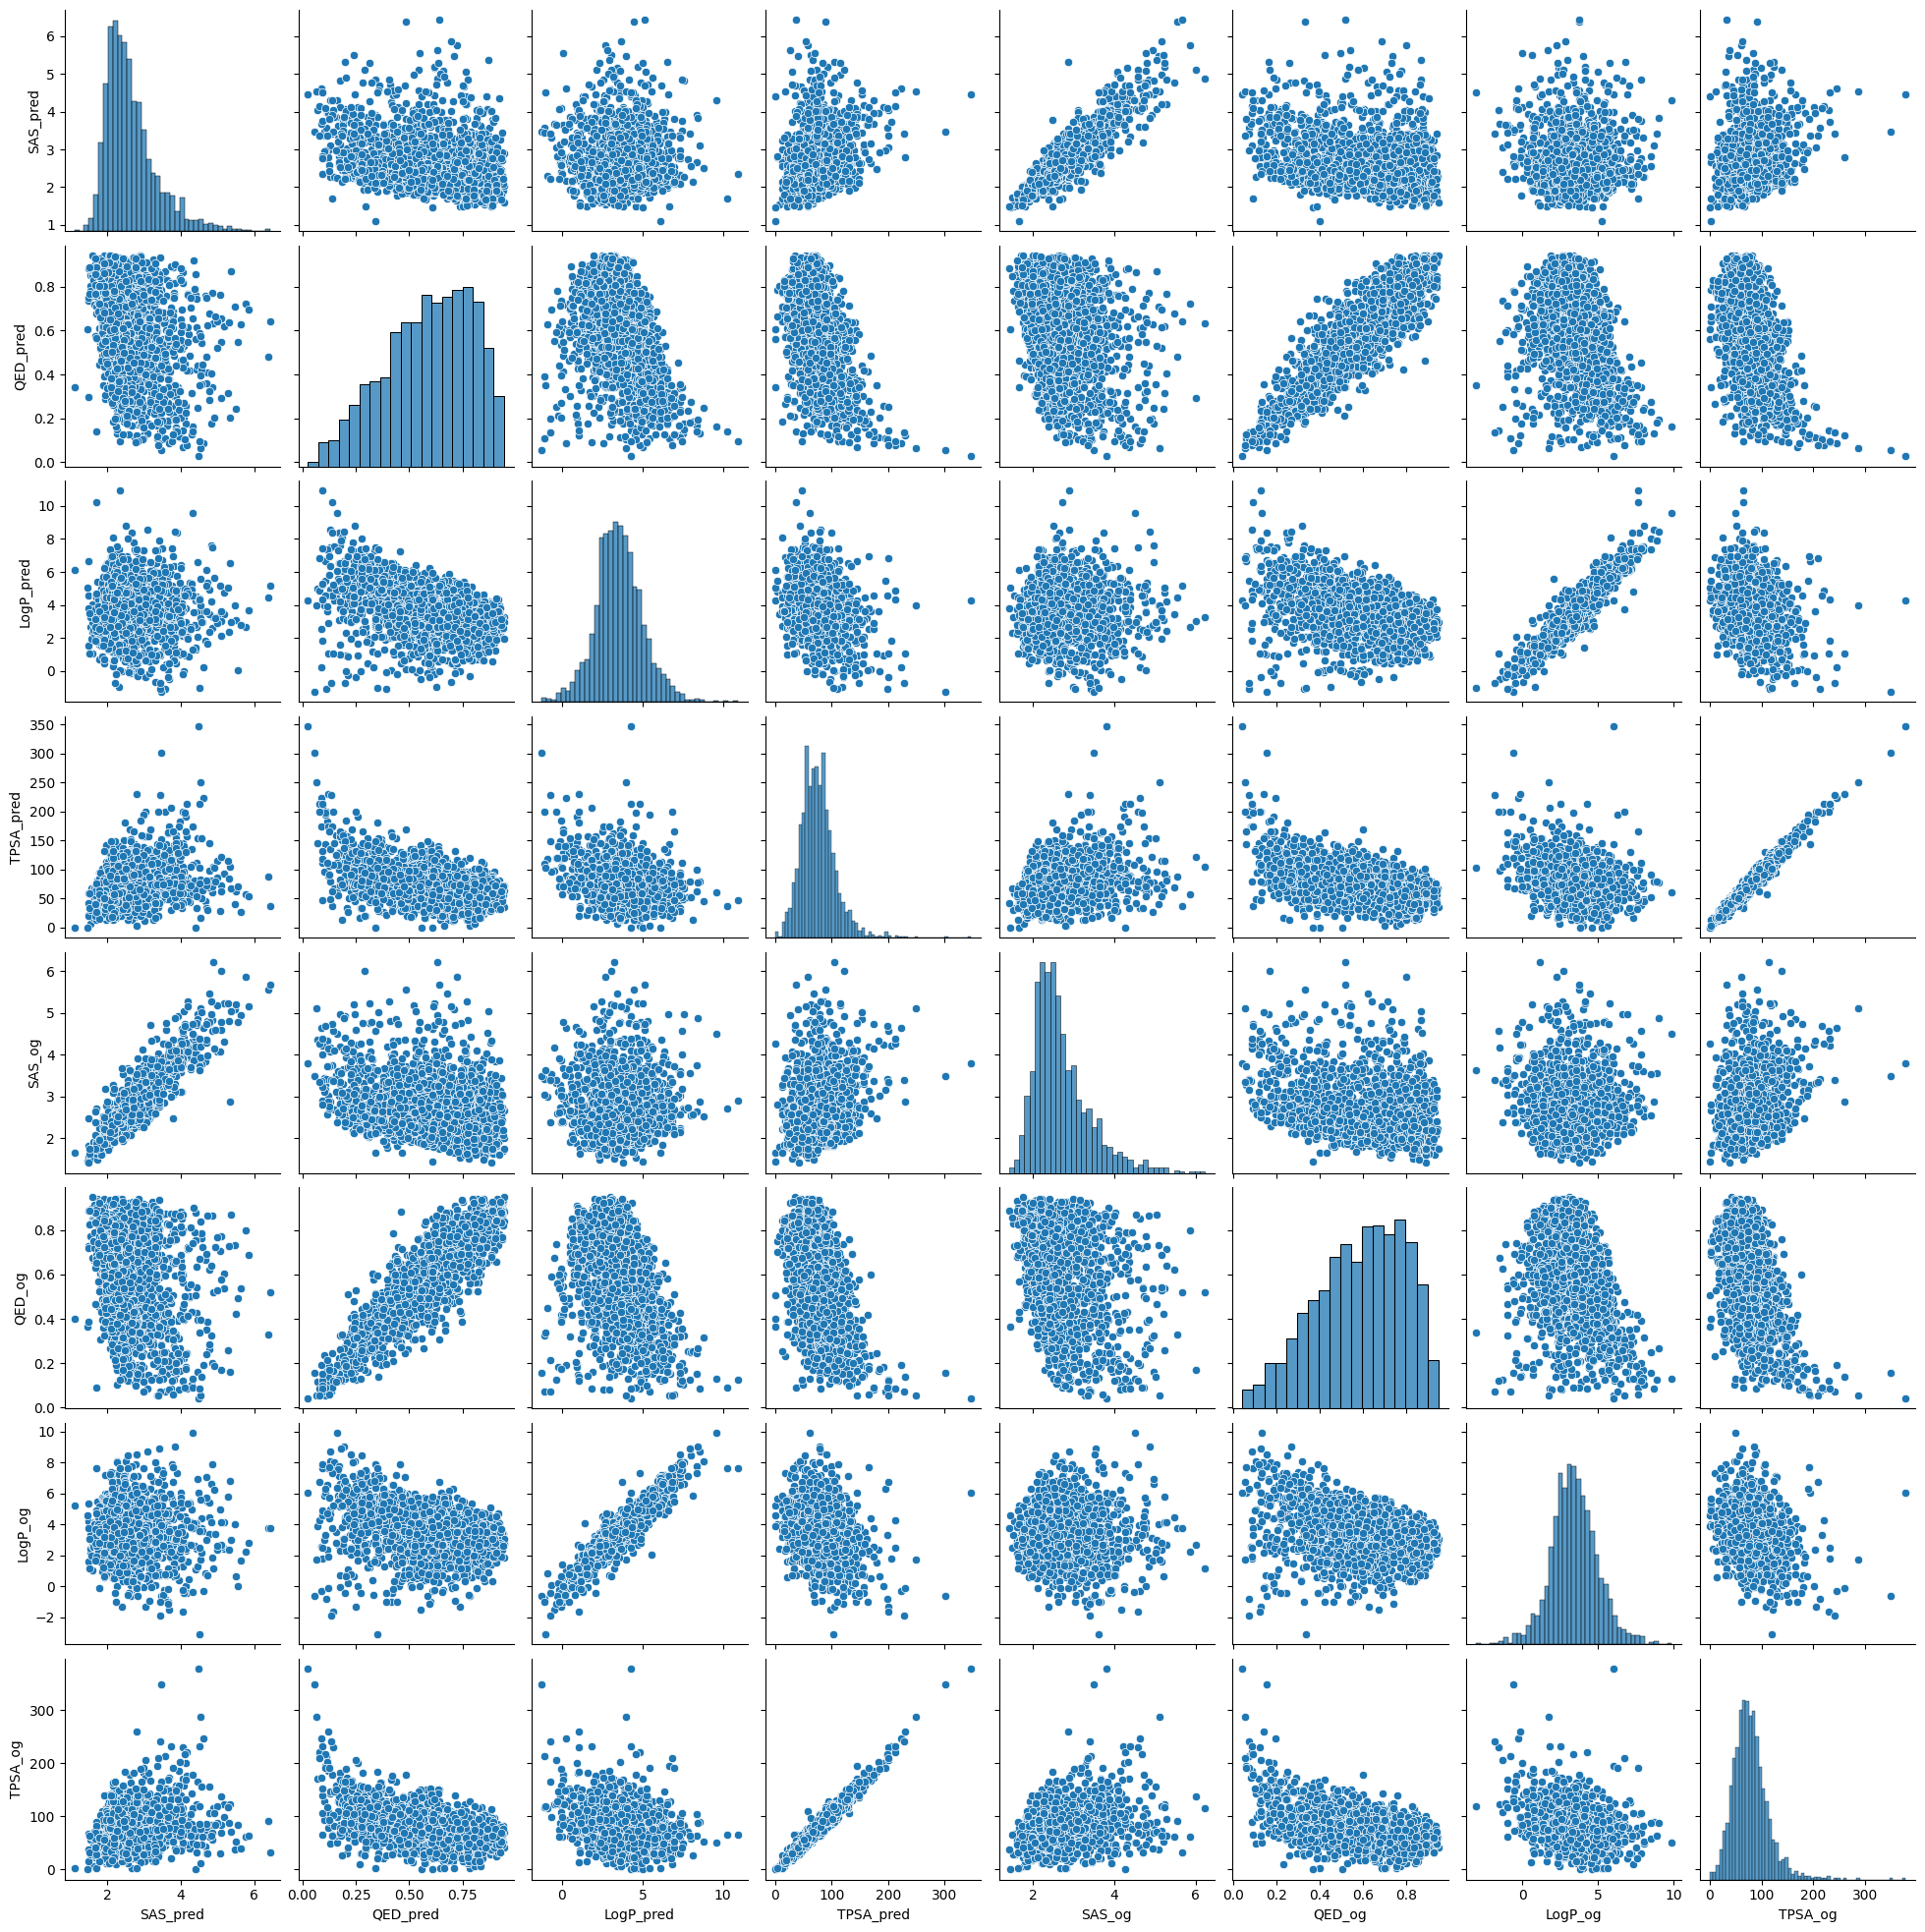

In [ ]:
sns.pairplot(stats)

In [70]:
target_props = {}
target_props['affinity'] = [-9, -8, -7]
target_props['logp'] = [2, 5]
# target_props['molwt'] = [280, 320]
target_props['qed'] = [0.3, 0.8]
target_props['tpsa'] = [40,100]
target_props['sas'] = [2, 4]

In [72]:
queries = []
property_vectors = []
for a in target_props['affinity']:
    for b in target_props['logp']:
        for c in target_props['qed']:
            for d in target_props['sas']:
                for e in target_props['tpsa']:
                    
                    key = str(a)+'-'+str(b)+'-'+str(c) + '-' + str(d) + '-' + str(e)
                    t = torch.Tensor([
                        affinity_scaler.transform([[a]]).flatten()[0],
                        logp_scaler.transform([[b]]).flatten()[0],
                        qed_scaler.transform([[c]]).flatten()[0],
                        sas_scaler.transform([[d]]).flatten()[0],
                        tpsas_scaler.transform([[e]]).flatten()[0]
                        ])
                    queries.append(key)
                    property_vectors.append(t)
property_vectors = torch.stack(property_vectors, dim=0)

In [73]:
sampler = Sampler(model, smiles_vocab)

In [75]:
results = {}
count = 0
for key, v in zip(queries, property_vectors):
    print(key, v)
    p = v.repeat(config['batch_size'], 1)
    samples = sampler.sample(p, greedy=False)
    if key in results:
        print("duplicate key", key)
    qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
    # results[key] = [logps, tpsas, qeds, samples]
    results[key] = [logps, qeds, sas, tpsas, samples]

    count += 1

-8-2-0.3-2-40 tensor([0.5714, 0.4638, 0.3106, 0.1468, 0.0805])


-8-2-0.3-2-100 tensor([0.5714, 0.4638, 0.3106, 0.1468, 0.2011])
-8-2-0.3-4-40 tensor([0.5714, 0.4638, 0.3106, 0.4405, 0.0805])
-8-2-0.3-4-100 tensor([0.5714, 0.4638, 0.3106, 0.4405, 0.2011])
-8-2-0.8-2-40 tensor([0.5714, 0.4638, 0.8424, 0.1468, 0.0805])
-8-2-0.8-2-100 tensor([0.5714, 0.4638, 0.8424, 0.1468, 0.2011])
-8-2-0.8-4-40 tensor([0.5714, 0.4638, 0.8424, 0.4405, 0.0805])
-8-2-0.8-4-100 tensor([0.5714, 0.4638, 0.8424, 0.4405, 0.2011])
-8-5-0.3-2-40 tensor([0.5714, 0.5918, 0.3106, 0.1468, 0.0805])
-8-5-0.3-2-100 tensor([0.5714, 0.5918, 0.3106, 0.1468, 0.2011])
-8-5-0.3-4-40 tensor([0.5714, 0.5918, 0.3106, 0.4405, 0.0805])
-8-5-0.3-4-100 tensor([0.5714, 0.5918, 0.3106, 0.4405, 0.2011])
-8-5-0.8-2-40 tensor([0.5714, 0.5918, 0.8424, 0.1468, 0.0805])
-8-5-0.8-2-100 tensor([0.5714, 0.5918, 0.8424, 0.1468, 0.2011])
-8-5-0.8-4-40 tensor([0.5714, 0.5918, 0.8424, 0.4405, 0.0805])
-8-5-0.8-4-100 tensor([0.5714, 0.5918, 0.8424, 0.4405, 0.2011])


In [77]:
import pickle
import pandas as pd
# dump results dictionary into a pickle file

# with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'wb') as f:
    # pickle.dump(results, f)



In [78]:
# with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'rb') as f:
    # results = pickle.load(f)

In [79]:
# new_results = {}
# for i, key in enumerate(results):
#     print(i)
#     samples = results[key][3]
#     qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
#     new_results[key] = [logps, qeds, sas, tpsas, samples]
# with open('../checkpoints/' + config['run_name'] +'/results.pkl', 'wb') as f:
#     pickle.dump(new_results, f)


In [82]:
data = []
columns = ['Target LogP', 'Target QED', 'Target SAS', 'Target TPSA', 'Predicted LogP','Predicted QED' ,'Predicted SAS','Predicted TPSA', 'key']
for key in results:
    keys = key.split('-')
    affinity = keys[1]
    logp = keys[2]
    qed = keys[3]
    sas = keys[4]
    tpsa = keys[5]
    for i in range(len(results[key][0])):
        data.append([logp, qed, sas, tpsa, results[key][0][i], results[key][1][i], results[key][2][i], results[key][3][i], key])

In [83]:
data_df = pd.DataFrame(data, columns=columns)

<AxesSubplot: xlabel='Predicted TPSA', ylabel='Density'>

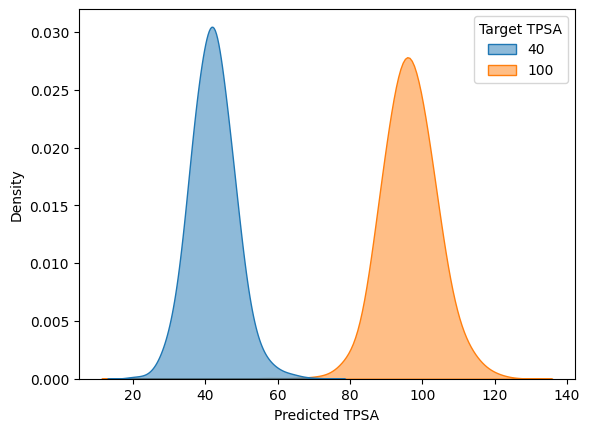

In [85]:
sns.kdeplot(data=data_df, x="Predicted TPSA",hue="Target TPSA", fill=True,alpha=.5, linewidth=1, bw_adjust=2)

<AxesSubplot: xlabel='Predicted LogP', ylabel='Density'>

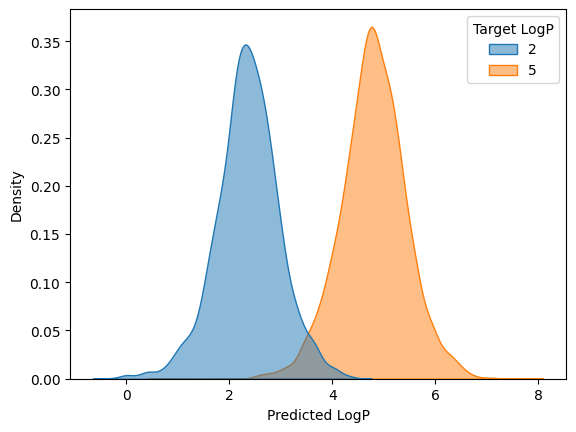

In [86]:
sns.kdeplot(data=data_df, x="Predicted LogP",hue="Target LogP", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted QED', ylabel='Density'>

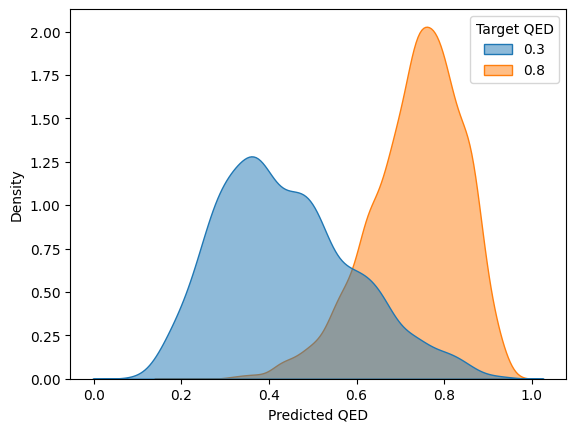

In [87]:
sns.kdeplot(data=data_df, x="Predicted QED",hue="Target QED", fill=True,alpha=.5, linewidth=1)

<AxesSubplot: xlabel='Predicted SAS', ylabel='Density'>

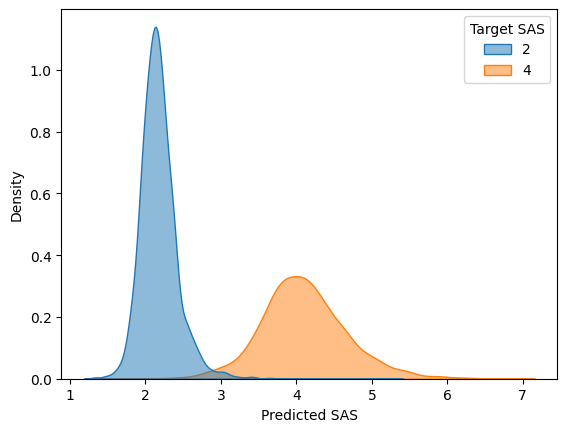

In [88]:
sns.kdeplot(data=data_df, x="Predicted SAS",hue="Target SAS", fill=True,alpha=.5, linewidth=1)

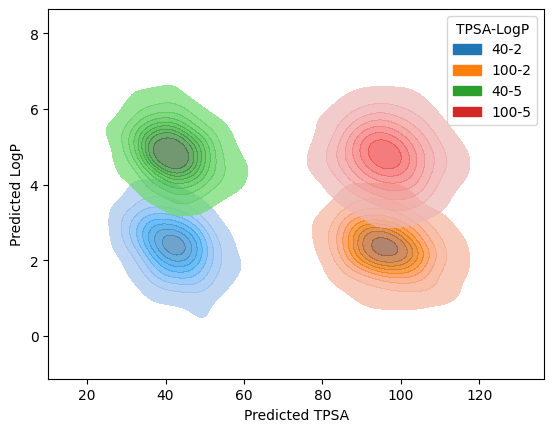

In [90]:
data_df['TPSA-LogP'] = data_df['Target TPSA'] +'-' +data_df['Target LogP']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted LogP", hue="TPSA-LogP", fill=True, alpha=0.7, bw_adjust=1.5)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
# sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))


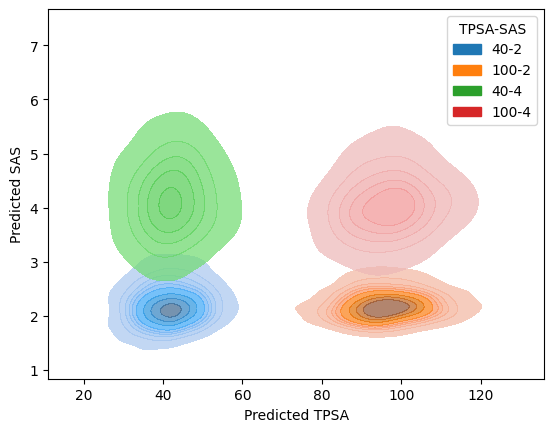

In [91]:
data_df['TPSA-SAS'] = data_df['Target TPSA'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted TPSA", y="Predicted SAS", hue="TPSA-SAS", fill=True, alpha=0.7, bw_adjust=1.5)

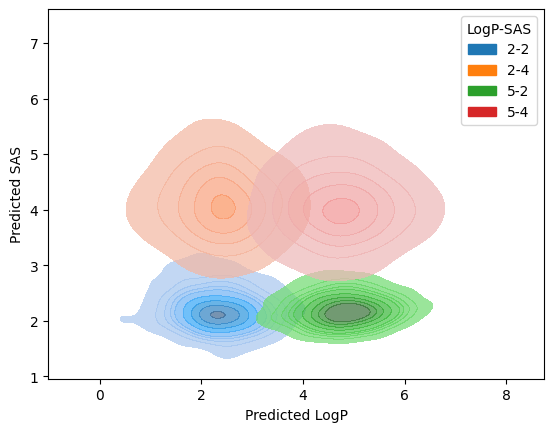

In [92]:
data_df['LogP-SAS'] = data_df['Target LogP'] +'-' +data_df['Target SAS']
ax = sns.kdeplot(data=data_df, x="Predicted LogP", y="Predicted SAS", hue="LogP-SAS", fill=True, alpha=0.7, bw_adjust=1.5)

In [ ]:
print(config)

In [ ]:
import pickle
import seaborn as sns
dist_data = pickle.load(open('../checkpoints/' + config['run_name'] + '/affinity_distribution.pkl', 'rb'))